<a href="https://colab.research.google.com/github/ShreyasJothish/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

In [0]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

persons_data_url = "https://raw.githubusercontent.com/LambdaSchool/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv"

#!curl $persons_data_url

In [2]:
# Loading the data and checking for inconsistencies

labels = ['uid','age','weight','exercise_time']
persons_data = pd.read_csv(persons_data_url)
persons_data.columns = labels
print(persons_data.head())
print(persons_data.shape)
persons_data.isnull().sum()

# dtype of variables
persons_data.dtypes

   uid  age  weight  exercise_time
0    0   44     118            192
1    1   41     161             35
2    2   46     128            220
3    3   39     216             57
4    4   28     116            182
(1200, 4)


uid              int64
age              int64
weight           int64
exercise_time    int64
dtype: object

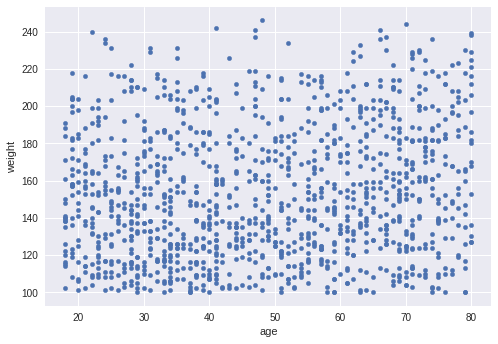

In [3]:
# Comparing weight with age
persons_data.plot.scatter(x = 'age', y = 'weight');

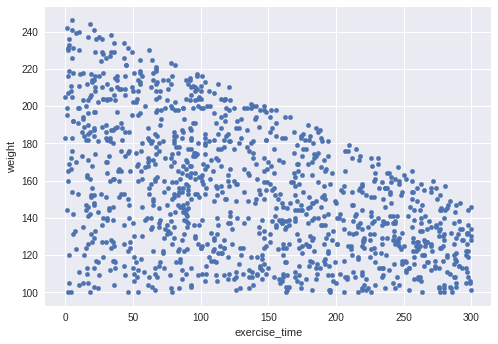

In [4]:
# Comparing weight with exercise_time
persons_data.plot.scatter(x = 'exercise_time', y = 'weight');

               uid          age       weight  exercise_time
count  1200.000000  1200.000000  1200.000000    1200.000000
mean    599.500000    48.396667   153.540833     134.910833
std     346.554469    18.166802    35.132182      85.548895
min       0.000000    18.000000   100.000000       0.000000
25%     299.750000    33.000000   125.000000      65.000000
50%     599.500000    48.000000   149.000000     122.000000
75%     899.250000    64.000000   180.250000     206.000000
max    1199.000000    80.000000   246.000000     300.000000


"pd.crosstab(exercise_time_bins, [persons_data['weight'], \n                                    persons_data['age']],\n                                    normalize='columns').plot(kind = 'bar', stacked = False);"

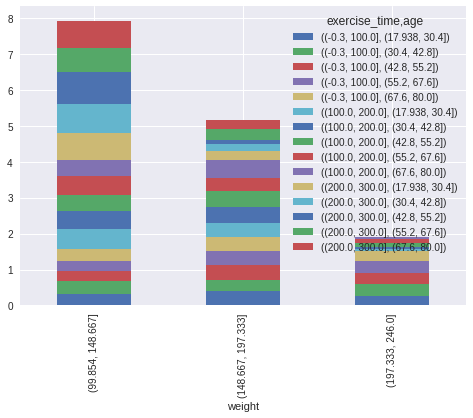

In [15]:
print(persons_data.describe())

# Binning all the groups
exercise_time_bins = pd.cut(persons_data['exercise_time'], 3)
age_bins = pd.cut(persons_data['age'], 5)
weight_bins = pd.cut(persons_data['weight'], 3)

crosstab_persons_data = pd.crosstab(weight_bins, [exercise_time_bins, 
                                    age_bins],
                                    normalize='columns')
crosstab_persons_data.plot(kind = 'bar', stacked = True);

"""pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
            normalize='columns').plot(kind = 'bar', stacked = False);"""

"""pd.crosstab(exercise_time_bins, [persons_data['weight'], 
                                    persons_data['age']],
                                    normalize='columns').plot(kind = 'bar', stacked = False);"""



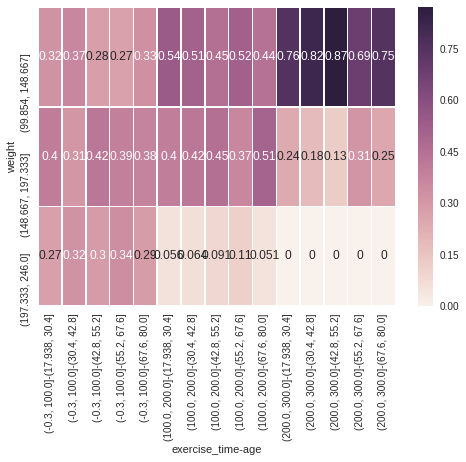

In [16]:
sns.heatmap(crosstab_persons_data, annot=True,  linewidths=.5)

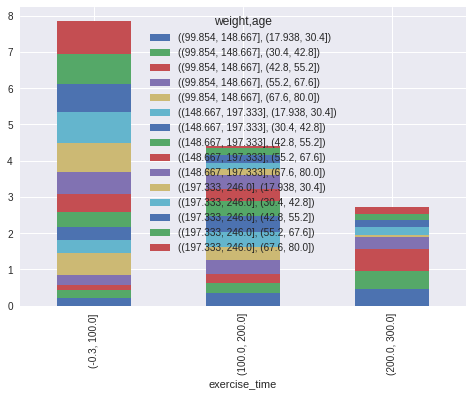

In [17]:
crosstab_persons_data = pd.crosstab(exercise_time_bins, [weight_bins, 
                                    age_bins],
                                    normalize='columns')
crosstab_persons_data.plot(kind = 'bar', stacked = True);

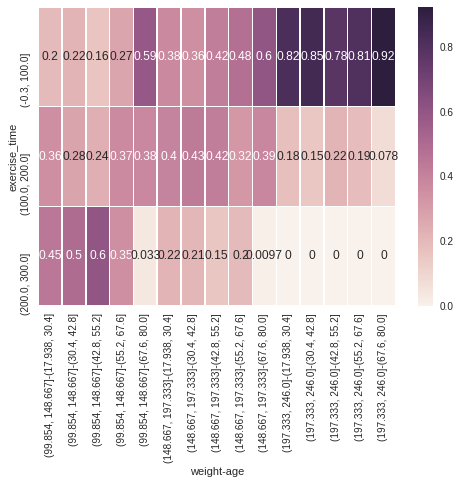

In [18]:
sns.heatmap(crosstab_persons_data, annot=True,  linewidths=.5)

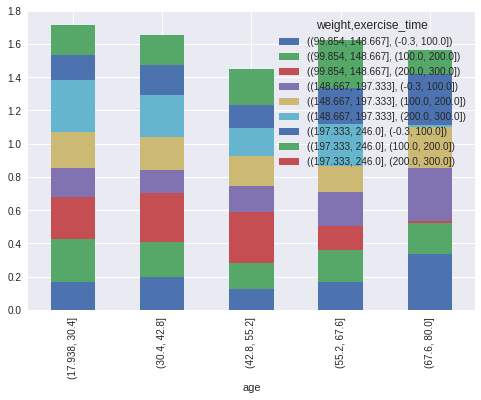

In [19]:
crosstab_persons_data = pd.crosstab(age_bins, [weight_bins, 
                                    exercise_time_bins],
                                    normalize='columns')
crosstab_persons_data.plot(kind = 'bar', stacked = True);

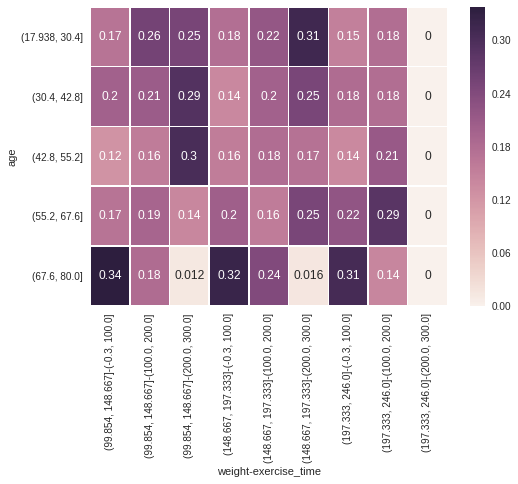

In [20]:
sns.heatmap(crosstab_persons_data, annot=True,  linewidths=.5)

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

**Answer:** All the data within the persons.csv are of type integers.

uid              int64
age              int64
weight           int64
exercise_time    int64

Column Name | Data Type
--- | ---
uid | int64
age | int64
weight | int64
exercise_time | int64

2.  What are the relationships between the variables?

**Answer:** From scatter plot it appears weigth has no dependency on age but weight is dependent on exercise_time. 

3.  Which relationships are "real", and which spurious?

**Answer:** On plotting crosstab plot, I need help is understanding the dependencies. 

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)